# TinyAES Attack

AES encryption :

/home/gata/Bureau/MA3/semester_project/project/hardware/victims/firmware/crypto/tiny-AES128-C

---
Objective : Redo paper https://eprint.iacr.org/2021/1252.pdf

---

## AES Python model

In [180]:
import numpy as np

sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

def calc_hamming_weight(n):
    return bin(n).count("1")

HW = []
for i in range(256):
    HW += [calc_hamming_weight(i)]
    
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

✔️ OK to continue!


In [181]:
# See https://github.com/boppreh/aes/

def pad(plaintext):
    padding_len = 16 - (len(plaintext) % 16)
    padding = bytes([padding_len] * padding_len)
    return plaintext + padding

def unpad(plaintext):
    padding_len = plaintext[-1]
    assert padding_len > 0
    message, padding = plaintext[:-padding_len], plaintext[-padding_len:]
    assert all(p == padding_len for p in padding)
    return message

def bytes2matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix.  """
    return [list(text[i:i+4]) for i in range(0, len(text), 4)]

def matrix2bytes(matrix):
    """ Converts a 4x4 matrix into a 16-byte array.  """
    return bytes(sum(matrix, []))

def xor_bytes(a, b):
    """ Returns a new byte array with the elements xor'ed. """
    return bytes(i^j for i, j in zip(a, b))

def print_byte_array_in_hex(array):
    tmp = np.array(list(map(lambda elem: hex(elem), array)))
    print(tmp)
    return tmp

def state_to_hamming_weight(s):
    for i in range(4):
        for j in range(4):
            s[i][j] = HW[s[i][j]]
            
def print_state_to_hex_str(s):
    for i in range(4):
        for j in range(4):
            s[i][j] = hex(s[i][j])
    #print(s)
    state_from_hex_str_to_int(s)
            
def state_from_hex_str_to_int(s):
    for i in range(4):
        for j in range(4):
            s[i][j] = int(s[i][j], 16)

In [182]:
bytes_msg = b"AES message"
tmp = (matrix2bytes(bytes2matrix(pad(bytes_msg))))
assert unpad(matrix2bytes(bytes2matrix(pad(bytes_msg)))) == bytes_msg
print("✔️ OK to continue!")

✔️ OK to continue!


In [183]:
# Addition key or Round key : AK
def add_round_key(s, k):
    for i in range(4):
        for j in range(4):
            s[i][j] ^= k[i][j]

# Sub-bytes or S-Box : SB
def sub_bytes(s):
    if type(s) != list:
        return sbox[s]
    elif type(s[0]) == list:
        for i in range(4):
            for j in range(4):
                s[i][j] = sbox[s[i][j]]
        return s
    elif type(s[0]) == int:
        for i in range(4):
            s[i] = sbox[s[i]]
        return s

# Shift rows or Permutation: PB
def shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]
    
def custom_shift_rows(plaintext, index):
    shift_rows = [0x00, 0x01, 0x02, 0x03, 0x05, 0x06, 0x07, 0x04, 0x0A, 0x0B, 0x08, 0x09, 0x0F, 0x0C, 0x0D, 0x0E]
    return s[shift_rows[index]]

# Diffusion layer or Mix Column : MC
xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)
    
def mix_single_column(a):
    t = a[0] ^ a[1] ^ a[2] ^ a[3]
    u = a[0]
    a[0] ^= t ^ xtime(a[0] ^ a[1])
    a[1] ^= t ^ xtime(a[1] ^ a[2])
    a[2] ^= t ^ xtime(a[2] ^ a[3])
    a[3] ^= t ^ xtime(a[3] ^ u)

def mix_columns(s):
    for i in range(4):
        mix_single_column(s[i])
        
# Key scheduling KS
r_con = (
    0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40,
    0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A,
    0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A,
    0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39,
)

def expand_key(master_key):
    # Initialize round keys with raw key material.
    key_columns = [bytes(elem) for elem in bytes2matrix(master_key)]
    iteration_size = len(master_key) // 4

    i = 1
    while len(key_columns) < (10 + 1) * 4:
        # Copy previous word.
        word = list(key_columns[-1])

        # Perform schedule_core once every "row".
        if len(key_columns) % iteration_size == 0:
            # Circular shift.
            word.append(word.pop(0))
            # Map to S-BOX.
            word = [sub_bytes(b) for b in word]
            # XOR with first byte of R-CON, since the others bytes of R-CON are 0.
            word[0] ^= r_con[i]
            i += 1
        elif len(master_key) == 32 and len(key_columns) % iteration_size == 4:
            # Run word through S-box in the fourth iteration when using a
            # 256-bit key.
            word = [sub_bytes(b) for b in word]

        # XOR with equivalent word from previous iteration.
        word = xor_bytes(word, key_columns[-iteration_size])
        key_columns.append(word)

    # Group key words in 4x4 byte matrices.
    return [key_columns[4*i : 4*(i+1)] for i in range(len(key_columns) // 4)]

In [184]:
# AES* - 10 rounds
def AES_128_enc(plaintext, key):
    assert len(plaintext) == 16

    plain_state = bytes2matrix(plaintext)

    add_round_key(plain_state, key[0])
    
    for i in range(1, 10):
        sub_bytes(plain_state)
        shift_rows(plain_state)
        mix_columns(plain_state)
        add_round_key(plain_state, key[i])

    sub_bytes(plain_state)
    shift_rows(plain_state)
    add_round_key(plain_state, key[10])

    return matrix2bytes(plain_state)

Test AES python implementation :

In [185]:
plaintext = bytes([0x00 for i in range(16)])
key = expand_key([0x00 for i in range(16)])

assert AES_128_enc(plaintext, key).hex() == "66e94bd4ef8a2c3b884cfa59ca342b2e"
print("✔️ OK to continue!")

✔️ OK to continue!


## AES with ChipWhisperer board

Connect and init. with ChipWhisperer board

In [ ]:
SCOPETYPE = 'OPENADC'
PLATFORM='CW308_STM32F4'
CRYPTO_TARGET='TINYAES128C'
AES_TINY_VERSION='V0'

In [ ]:
%run "Setup_Scripts/Setup_Generic.ipynb"

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$AES_TINY_VERSION"
cd hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 AES_TINY_VERSION=$3

In [ ]:
cw.program_target(scope, prog, "hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

In [ ]:
project = cw.create_project("traces/STM32F4_HW_AES.cwp", overwrite=True)

Test board receive/send

In [ ]:
# Read from board
# Read Debug
recv_msg = ""
sub_read = target.read()
while sub_read != "":
    recv_msg += sub_read
    sub_read = target.read()

assert "hello" in recv_msg
print("✔️ OK to continue!")

## Test AES.c implementation

In [ ]:
import tqdm
import numpy as np
import time

ktp = cw.ktp.Basic()
key, text = ktp.next() 
target.set_key(key)

In [ ]:
plaintext = bytes([0x00 for i in range(16)])
key = [0x00 for i in range(16)]
key_exp = expand_key(key)
result = 0x66e94bd4ef8a2c3b884cfa59ca342b2e

In [ ]:
key = bytearray(key)
text = bytearray(plaintext)

target.set_key(key)

scope.arm()

target.simpleserial_write('p', text)
ret = scope.capture()

if ret:
    print("Target timed out!")

response = target.simpleserial_read('r', 16)

result_c = ""
for byte in response:
    result_c += hex(byte)[2:]

assert int(result_c, 16) == result
print("✔️ OK to continue!")

## DPA Attack based on tuto

In [ ]:
import tqdm
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next() 



target.set_key(key)

N = 2500
for i in tqdm.trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace_array)
plt.show()

In [ ]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

In [ ]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

In [ ]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in tqdm.tnrange(0, 16, desc="Attacking Subkey"):
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

# DPA Attack based on paper

In [ ]:
# Set the key
def set_up(key):
    target.set_key(bytearray(key))
    
# Encrypt plaintext p once and returns its power trace
import time

def encrypt_p_power(p):
    scope.arm()
    
    target.simpleserial_write('p', bytearray(p))
    
    
    time.sleep(0.009)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
    
    trace_array = scope.get_last_trace()
    return trace_array

# Encrypt plaintext p n-times and returns average power trace
def encrypt_p_power_repeat_n(p, n):
    res = np.array(encrypt_p_power(p))
    for i in range(n - 1):
        tmp = np.array(encrypt_p_power(p))
        res += tmp
    return (1/n*res).tolist()

Record one power trace to identify in it operations

In [ ]:
plaintext = [0x00 for i in range(16)]
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)

MAX_cwlite = 24400
scope.adc.samples = 9000

avg_trace = encrypt_p_power_repeat_n(plaintext, 1000)

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (8,3)

plt.figure()
plt.plot(avg_trace)
plt.show()

### BLOCK COPY

![alt text](Block_copy.png "Block Copy")


In [ ]:
# FOR BLOCK COPY
spikes = np.array(avg_trace[0:440])
index = np.where(spikes >= 0.0525)[0]
index = index[index > 65]

print(index)
#assert len(index) == 16 # REDO
index = np.array([76, 100, 124, 148, 172, 196, 220, 244, 268, 292, 316, 340, 364, 388, 412, 436])

BlockCopy behaviour

key = 0x00 0xFF 0x00 ...

index = [ 76  92  95  96 100 124 148 172 196 220 244 268 292 316 340 364 388 412
 436]

key = 0xFF 0x00 ...

index = [ 71  72  76 100 124 148 172 196 220 244 268 292 316 340 364 388 412 436]


key = 0x00 0x00 ...

index = [ 76 100 124 148 172 196 220 240 244 268 292 316 340 364 388 412 436]

### ROUND KEY


![alt text](round_key_16_spikes0.png "16 spikes for RK")

In [ ]:
# FOR AC(0)
spikes = np.array(avg_trace[0:1300])
index = np.where(spikes >= 0.070)[0]
index = index[index > 580]

print(index)
#assert len(index) == 16 # REDO
index = np.array([600, 640, 680, 720, 784, 824, 864, 904, 968, 1008, 1048, 1088,1152, 1192, 1232, 1272])

### SHIFT ROWS

![alt text](Shift_Rows.png "16 spikes for RK")

In [88]:
# FOR SHIFT ROWS (PB)
def find_best_occurances(sub_trace, overall_trace):
    length = np.shape(sub_trace)[0]
    best_i = 0
    avg = float('inf')
    for i in range(np.shape(overall_trace)[0] - length):
        avg_tmp = np.sum(np.abs(overall_trace[i:i+length] - sub_trace), axis = 0)
        if avg_tmp < avg:
            best_i = i 
            avg = avg_tmp
    return best_i

def insert_0(index_0_left, index_0_right, overall_trace):
    assert index_0_right >= index_0_left
    assert index_0_left >= 0
    return np.concatenate((overall_trace[:index_0_left], np.zeros(index_0_right - index_0_left - 1), overall_trace[index_0_left:]))

In [ ]:
%run "Setup_Scripts/Setup_Generic.ipynb"
AES_TINY_VERSION='V1'

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$AES_TINY_VERSION"
cd hardware/victims/firmware/simpleserial-aes-2
make PLATFORM=$1 CRYPTO_TARGET=$2  AES_TINY_VERSION=$3

In [ ]:
cw.program_target(scope, prog, "hardware/victims/firmware/simpleserial-aes-2/simpleserial-aes-{}.hex".format(PLATFORM))
project = cw.create_project("traces/STM32F4_HW_AES_2.cwp", overwrite=True)

In [ ]:
plaintext = [0x00 for i in range(16)]
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)

MAX_cwlite = 24400
scope.adc.samples = 9000

In [ ]:
start_index = 2250
stop_index = 2450
avg_trace_zoom = np.array(avg_trace[start_index:stop_index])
avg_trace_zoom_bis = encrypt_p_power_repeat_n(plaintext, 1000)[start_index:stop_index]

In [ ]:
# Determine first difference in two traces
print(np.argwhere(np.abs(avg_trace_zoom_bis - avg_trace_zoom) > 1.0e-02)[0, 0])

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (8,3)

plt.figure()
plt.plot(avg_trace_zoom)
plt.plot(insert_0(59, 108, avg_trace_zoom_bis), '-')
plt.show()

### Overall trace with operation indices

BlockCopy: 20 - 500

Round key (AK) : 590 - 1265

Sub bytes (SB) : 1390 - 2200

Shift rows (PB) : 2260 - 2500

Mix Columns (MC) : 2500 - 3200

Round key (AK) : 3250 - 4000

## Algo 1

### Recovering first byte of the key (i = 0)

In [ ]:
def algo1_recover_ith_key_byte(p, i): # p = byte_msg, i subkey
    J = [0 for j in range(256)]
    for t in range(256): # t is guess 
        print(f"{t}/256", end='\r')
        p[i] = t
        # WITH RANGE INDICES : 
        e = np.array(encrypt_p_power_repeat_n(p, 30)[index[i] - 1:index[i]]).mean(axis = 0) # b_i,AK(0)
        # WITH ONLY ONE INDICE :
        # e = np.array(encrypt_p_power_repeat_n(p, 10)[index[i]]) # b_i,AK(0)
        # LIKE TUTO WITH S_BOX Leak model
        # e = np.max(calculate_diffs(t, i))
        J[t] = e
    print("Done   ")
    t_min = np.argsort(np.array(J))
    return J, t_min

In [ ]:
i = 0
J, res = algo1_recover_ith_key_byte(plaintext, i)

#Print results
print("Subkey %2d - most likely %02X (actual %02X)"%(i, res[0], key[i]))

#Print other top guesses
print(" Top 5 guesses: ")
for j in range(0, 5):
    print("   %02X - averge power trace: %.3f"%(res[j], J[res[j]]))
print("\n")

### Estimate best index range of AC operation

In [ ]:
def algo1_recover_ith_key_byte_range(p, i, l, m): # p = byte_msg, i subkey, l and m are positive integers s.t indices range are equal to [index - l, index + m)
    J = [0 for j in range(256)]
    for t in range(256): # t is guess 
        print(f"{t}/256", end='\r')
        p[i] = t
        if l == 0 and m == 0:
            e = np.array(encrypt_p_power_repeat_n(p, 1)[index[i]]) # b_i,AK(0)
        else:
            e = np.array(encrypt_p_power_repeat_n(p, 1)[index[i] - l:index[i] + m]).mean(axis = 0) # b_i,AK(0) [index - l, index + m)
        # e = np.max(calculate_diffs(t, i))
        J[t] = e
    print("Done     ", end='\r')
    t_min = np.argsort(np.array(J))
    return J, t_min

In [ ]:
i = 0
diff_trace_list = []
for l in range(5):
    for m in range(5):
        J, res = algo1_recover_ith_key_byte_range(plaintext, i, l, m)
        print("Subkey %2d - most likely %02X (actual %02X)"%(i, res[0], key[i]))
        print(f"l = -{l}, m = {m}")
        print(f"Average power trace : {J[res[0]]}")
        if res[0] == key[i]:
            diff_trace_list += [J[res[1]] - J[res[0]]]
        else: 
            diff_trace_list += [0]

sorted_increasing_diff_trace_list = np.argsort(np.array(diff_trace_list))[::-1]

for n in range(0, 5):
    print(f"Best {n}th indices : l = {sorted_increasing_diff_trace_list[n]//5}, m = {sorted_increasing_diff_trace_list[n]%5}")

Best 0th indices : l = 1, m = 1
Best 1th indices : l = 3, m = 2
Best 2th indices : l = 3, m = 1
Best 3th indices : l = 2, m = 1
Best 4th indices : l = 4, m = 4

In [ ]:
score_list = []
for l in range(5):
    for m in range(5):
        score = 0
        print(f"{5*l + m}       ")
        for n in range(50):
            J, res = algo1_recover_ith_key_byte_range(plaintext, i, l, m)
            if res[0] == key[0]:
                score += 1
        score_list += [score]
        
best_score = np.argsort(np.array(score_list))[::-1]
for n in range(0, 5):
    print(f"Best {n}th indices : l = {best_score[n]//5}, m = {best_score[n]%5}")

Best 0th indices : l = 1, m = 0
Best 1th indices : l = 4, m = 1
Best 2th indices : l = 4, m = 0
Best 3th indices : l = 2, m = 1
Best 4th indices : l = 3, m = 1

### Recover full key

In [ ]:
# Recover all key 

def recover_key(p): # p = byte_msg
    i_guess_list = []
    for i in range(16):
        J, res = algo1_recover_ith_key_byte(p, i)
        print("Subkey %2d - most likely %02X (actual %02X)"%(i, res[0], key[i]))
        print(" Top 5 guesses: ")
        for j in range(0, 5):
            print("   %02X - averge power trace: %.3f: "%(res[j], J[res[j]]))
        print("\n")
        i_guess_list += [res[0]]
    return i_guess_list

In [ ]:
key_guess = recover_key(plaintext)
assert key_guess == key

## Attack on ShiftRows

In [ ]:
plaintext = [0x00 for i in range(16)]
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)

MAX_cwlite = 24400
scope.adc.samples = 9000

avg_trace = np.array(encrypt_p_power_repeat_n(plaintext, 1000))

plaintext_0_shift = [0x00 for i in range(3)] + [0xFF] + [0x00 for i in range(12)]
plaintext_1_shift = [0x00 for i in range(7)] + [0xFF] + [0x00 for i in range(8)]
plaintext_2_shift = [0x00 for i in range(11)] + [0xFF] + [0x00 for i in range(4)]
plaintext_3_shift = [0x00 for i in range(15)] + [0xFF]

avg_trace_0_shift = np.array(encrypt_p_power_repeat_n(plaintext_0_shift, 1000))
avg_trace_1_shift = np.array(encrypt_p_power_repeat_n(plaintext_1_shift, 1000))
avg_trace_2_shift = np.array(encrypt_p_power_repeat_n(plaintext_2_shift, 1000))
avg_trace_3_shift = np.array(encrypt_p_power_repeat_n(plaintext_3_shift, 1000))

In [ ]:
power_trace_diff_1 = np.abs(avg_trace_0_shift - avg_trace) 
power_trace_diff_2 = np.abs(avg_trace_1_shift - avg_trace) 
power_trace_diff_3 = np.abs(avg_trace_2_shift - avg_trace) 
power_trace_diff_4 = np.abs(avg_trace_3_shift - avg_trace) 

In [ ]:
MC_low_index = 2500
MC_high_index = 3200

%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (8,3)

plt.figure()
plt.plot(power_trace_diff_1[MC_low_index:MC_high_index], label = "0th row : No shift") # Observe diff. at MC (between 2500 - 3200)
plt.plot(power_trace_diff_2[MC_low_index:MC_high_index], label = "1st row : 1 shift")
plt.plot(power_trace_diff_3[MC_low_index:MC_high_index], label = "2nd row : 2 shifts")
plt.plot(power_trace_diff_4[MC_low_index:MC_high_index], label = "3rd row : 3 shifts")
plt.legend(loc="upper left")
plt.show()

## Attack on Mix Columns

## Algo 2

In [ ]:
def algo2(p, i):
    old_offset = scope.adc.offset 
    old_samples = scope.adc.samples
    
    # AK(0) : 590 - 1265
    #scope.adc.offset = 590 # AK0_low_index = 590
    #scope.adc.samples = 1265 - 590 # AK0_high_index = 1265
    # SB(1)
    scope.adc.offset = 1350
    scope.adc.samples = 2263
    
    L = {255:0, 246:1, 210:2, 126:3, 0:4, -126:5, -210:6, -246:7, -255:8}
    e = encrypt_p_power_repeat_n(p, 50) # average trace
    h = 0
    for t in range(256):
        print(t)
        p[i] = t
        e_p = encrypt_p_power_repeat_n(p, 50)
        # Count how many t have a larger/smaller Hamming weight.
        #e_p_count = np.count_nonzero(np.array(e_p) - np.array(e) > 0)
        #e_count = len(e) - e_p_count
        e_count = np.sum(np.abs(np.array(e)))
        e_p_count = np.sum(np.abs(np.array(e_p)))
        
        if e_p_count < e_count:
            h = h - 1
        elif e_p_count > e_count:
            h = h + 1
    tmp_min_fct = float('inf')
    h_0_best = None
    for h_0 in L.keys():
        if abs(h - h_0) <= tmp_min_fct:
            h_0_best = h_0
            tmp_min_fct = abs(h - h_0)
            
    scope.adc.offset = old_offset
    scope.adc.samples = old_samples
    
    return L[h_0_best]

In [ ]:
algo2(plaintext, 0)

In [ ]:
def find_active_column(avg_trace_shift, avg_trace):
    argmax = np.argmax(np.abs(np.array(avg_trace_shift[MC_low_index:MC_high_index]) - np.array(avg_trace[MC_low_index:MC_high_index])))
    if argmax >= 0 and argmax <= 190:
        return 0
    if argmax <= 370:
        return 3
    if argmax <= 510:
        return 2
    if argmax <= 700:
        return 1

In [ ]:
set_u = 0xFF

def find_u_activating_jth_column(plaintext, j):
    avg_trace = encrypt_p_power_repeat_n(plaintext, 100)
    u_result = []
    for i in range(16):
        assert plaintext[i] != set_u
        tmp = plaintext[i]
        plaintext[i] = set_u
        avg_trace_shift = encrypt_p_power_repeat_n(plaintext, 100)
        if find_active_column(avg_trace_shift, avg_trace) == j:
            u_result += [i]
        plaintext[i] = tmp
    return u_result

### Working with custom/random shift rows

In [ ]:
SCOPETYPE = 'OPENADC'
PLATFORM='CW308_STM32F4'
CRYPTO_TARGET='TINYAES128C'
%run "Setup_Scripts/Setup_Generic.ipynb"
AES_TINY_VERSION='V2'

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$AES_TINY_VERSION"
cd hardware/victims/firmware/simpleserial-aes-3
make PLATFORM=$1 CRYPTO_TARGET=$2  AES_TINY_VERSION=$3

In [ ]:
cw.program_target(scope, prog, "hardware/victims/firmware/simpleserial-aes-3/simpleserial-aes-{}.hex".format(PLATFORM))
project = cw.create_project("traces/STM32F4_HW_AES_3.cwp", overwrite=True)

In [ ]:
plaintext = [0x00 for i in range(16)]
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)

MAX_cwlite = 24400
scope.adc.samples = 10000

avg_trace = encrypt_p_power_repeat_n(plaintext, 1000)

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (8,3)

plt.figure()
plt.plot(avg_trace)
plt.show()

BlockCopy: 20 - 500

Round key (AK) : 590 - 1265

Sub bytes (SB) : 1390 - 2200

Shift rows (PB) : 2200 - 5050

Mix Columns (MC) : 5050 - 5800

Round key (AK) : 5800 - 6550


In [ ]:
plaintext = [0x00 for i in range(16)]
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)

MAX_cwlite = 24400
scope.adc.samples = 9000

avg_trace = np.array(encrypt_p_power_repeat_n(plaintext, 1000))

plaintext_0_shift = [0x00 for i in range(3)] + [0xFF] + [0x00 for i in range(12)]
plaintext_1_shift = [0x00 for i in range(7)] + [0xFF] + [0x00 for i in range(8)]
plaintext_2_shift = [0x00 for i in range(11)] + [0xFF] + [0x00 for i in range(4)]
plaintext_3_shift = [0x00 for i in range(15)] + [0xFF]

avg_trace_0_shift = np.array(encrypt_p_power_repeat_n(plaintext_0_shift, 1000))
avg_trace_1_shift = np.array(encrypt_p_power_repeat_n(plaintext_1_shift, 1000))
avg_trace_2_shift = np.array(encrypt_p_power_repeat_n(plaintext_2_shift, 1000))
avg_trace_3_shift = np.array(encrypt_p_power_repeat_n(plaintext_3_shift, 1000))

In [ ]:
power_trace_diff_1 = np.abs(avg_trace_0_shift - avg_trace) 
power_trace_diff_2 = np.abs(avg_trace_1_shift - avg_trace) 
power_trace_diff_3 = np.abs(avg_trace_2_shift - avg_trace) 
power_trace_diff_4 = np.abs(avg_trace_3_shift - avg_trace) 

In [ ]:
MC_low_index = 5050
MC_high_index = 5800

%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (8,3)

plt.figure()
plt.plot(power_trace_diff_1[MC_low_index:MC_high_index], label = "0th row : No shift") # Observe diff. at MC (between 2500 - 3200)
plt.plot(power_trace_diff_2[MC_low_index:MC_high_index], label = "1st row : 1 shift")
plt.plot(power_trace_diff_3[MC_low_index:MC_high_index], label = "2nd row : 2 shifts")
plt.plot(power_trace_diff_4[MC_low_index:MC_high_index], label = "3rd row : 3 shifts")
plt.legend(loc="upper left")
plt.show()

In [ ]:
def find_active_column(avg_trace_shift, avg_trace):
    # argmax = np.argmax(np.abs(np.array(avg_trace_shift[MC_low_index:MC_high_index]) - np.array(avg_trace[MC_low_index:MC_high_index])))
    argmax = np.argmax(np.abs(np.array(avg_trace_shift[:]) - np.array(avg_trace[:])))
    #print(f"argmax : {argmax}")
    if argmax >= 0 and argmax <= 220:
        return 0
    if argmax <= 370:
        return 1
    if argmax <= 550:
        return 2
    if argmax <= 720:
        return 3
    
set_u = 0xFF

def find_u_activating_jth_column(avg_trace, plaintext, j):
    u_result = []
    for i in range(16):
        assert plaintext[i] != set_u
        tmp = plaintext[i]
        plaintext[i] = set_u
        avg_trace_shift = encrypt_p_power_repeat_n(plaintext, 50)
        #print(f"j : {j}")
        #print(f"i : {i}")
        if find_active_column(avg_trace_shift, avg_trace) == j:
            u_result += [i]
        plaintext[i] = tmp
    return u_result

### Software test

In [ ]:
plain_state = bytes2matrix(plaintext)

add_round_key(plain_state, key[0])
    

sub_bytes(plain_state)
print(plain_state)
state_to_hamming_weight(plain_state)
w_i = []

for i in range(4):
    for j in range(4):
        w_i += [plain_state[i][j]]

print(w_i)

In [ ]:
tmp = [0xdb, 0x13, 0x53, 0x45]
mix_single_column(tmp)
print(tmp)

In [ ]:
# Step 1

plaintext = [0x79, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x47, 0x00] + [0x00, 0x00, 0x00, 0x04]
plaintext_p = [0x68, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x68, 0x00] + [0x00, 0x00, 0x00, 0x04]

key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
key = expand_key(key)

plaintext_state = bytes2matrix(plaintext)
add_round_key(plaintext_state, key[0]) 
sub_bytes(plaintext_state)
shift_rows(plaintext_state)
# mix_columns(plaintext_state) 
b_PB_1 = matrix2bytes(plaintext_state)

plaintext_p_state = bytes2matrix(plaintext_p)
add_round_key(plaintext_p_state, key[0]) 
sub_bytes(plaintext_p_state)
shift_rows(plaintext_p_state)
#print_state_to_hex_str(plaintext_p_state)
#mix_columns(plaintext_p_state)
b_PB_1_p = matrix2bytes(plaintext_p_state)


# 0. Compute d0, d1, d2, d3
d_list = []
for i in range(4):
    d_list += [(b_PB_1[i] ^ b_PB_1_p[i]) & 0xFF]

In [ ]:
# 2
tmp = plaintext.copy()
for i in range(256):
    tmp[0] = i
    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    if plaintext_state[0][0] == 0x00:
        print(hex(i))
        
tmp = plaintext.copy()
for i in range(256):
    #tmp[4*1 + 1] = i
    tmp[4*2 + 2] = i
    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    #if plaintext_state[1][1] == 0x00:
    if plaintext_state[2][2] == 0x00:
        print(hex(i))

# Step 1 : p_u(0) = 0x79
# Step 1 : p_u(1) = 0xFC
# Step 2 : p_u(0) = 0x79
# Step 2 : p_u(1) = 0xFC
# Step 3 : p_u(0) = 0x79
# Step 3 : p_u(1) = 0xFC
# Step 4 : p_u(0) = 0x79
# Step 4 : p_u(1) = 0xFC
# Step 5 : p_u(0) = 0x79
# Step 5 : p_u(1) = 0xFC
# Step 6 : p_u(0) = 0x79
# Step 6 : p_u(1) = 0xFC
# Step 7 : p_u(0) = 0x79
# Step 7 : p_u(1) = 0xFC
# Step 8 : p_u(0) = 0x79
# Step 8 : p_u(1) = 0xFC
# Step 9 : p_u(0) = 0x79
# Step 9 : p_u(2) = 0x47
# Step 10 : p_u(0) = 0x79
# Step 10 : p_u(2) = 0x47
# Step 11 : p_u(0) = 0x79
# Step 11 : p_u(2) = 0x47

In [ ]:
# 3.
# Loop of p_u0_p, st H(b_u0_p, SB(1)) = 8
tmp = plaintext_p.copy()

for i in range(256):
    #tmp[0] = i
    #tmp[4*1 + 1] = i
    tmp[4*2 + 2] = i
    
    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    #if HW[plaintext_state[0][0]] == 8:
    #if HW[plaintext_state[1][1]] == 8:
    if HW[plaintext_state[2][2]] == 8:
        print(hex(i))
        
# Step 1 : p_u_p(0) = 0x56
# Step 2 : p_u_p(1) = 0xd3
# Step 3 : p_u_p(0) = 0x56
# Step 4 : p_u_p(1) = 0xd3
# Step 5 : p_u_p(0) = 0x56
# Step 6 : p_u_p(1) = 0xd3
# Step 7 : p_u_p(0) = 0x56
# Step 8 : p_u_p(1) = 0xd3
# Step 9 : p_u_p(0) = 0x56
# Step 10 : p_u_p(2) = 0x68
# Step 11 : p_u_p(0) = 0x56
# Step 12 : p_u_p(2) = 0x68

In [ ]:
# 4
tmp = plaintext.copy()
tmp2 = plaintext_p.copy()
    
for i in range(256):

    #tmp2[4*1 + 1] = i
    tmp2[0] = i
    #tmp2[4*2 + 2] = i
    
    #var_bar = tmp[4*1 + 1]
    var_bar = tmp[0]
    #var_bar = tmp[4*2 + 2]

    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    shift_rows(plaintext_state)
    mix_columns(plaintext_state)

    plaintext_state_p = bytes2matrix(tmp2)

    add_round_key(plaintext_state_p, key[0])
    sub_bytes(plaintext_state_p)
    shift_rows(plaintext_state_p)
    mix_columns(plaintext_state_p)

    #if plaintext_state[0][0] == plaintext_state_p[0][0]:
    if plaintext_state[0][1] == plaintext_state_p[0][1]:
    #if plaintext_state[0][2] == plaintext_state_p[0][2]:
    #if plaintext_state[0][3] == plaintext_state_p[0][3]:
        if var_bar != i:
            print(hex(i))
        
# Step 1 : p_u_p(1) = 0xcc
# Step 2 : p_u_p(0) = 0xd8
# Step 3 : p_u_p(1) = 0xaa
# Step 4 : p_u_p(0) = 0x1
# Step 5 : p_u_p(1) = 0xd3
# Step 6 : p_u_p(0) = 0x56
# Step 7 : p_u_p(1) = 0xed
# Step 8 : p_u_p(0) = 0xc6
# Step 9 : p_u_p(2) = 0x3f
# Step 10 : p_u_p(0) = 0x2f
# Step 11 : p_u_p(2) = 0xf8
# Step 11 : p_u_p(0) = 0x68

In [ ]:
# 5

tmp = plaintext_p.copy()
    
plaintext_state = bytes2matrix(tmp)
add_round_key(plaintext_state, key[0])  
sub_bytes(plaintext_state)
#print(hex(plaintext_state[1][1]))
#print(HW[plaintext_state[1][1]])
print(hex(plaintext_state[0][0]))
print(HW[plaintext_state[0][0]])
#print(hex(plaintext_state[2][2]))
#print(HW[plaintext_state[2][2]])

# Step 1 : H(b_u(1)_p) = 4
# Step 2 : H(b_u(0)_p) = 3
# Step 3 : H(b_u(1)_p) = 5
# Step 4 : H(b_u(0)_p) = 5
# Step 5 : H(b_u(1)_p) = 8
# Step 6 : H(b_u(0)_p) = 8
# Step 7 : H(b_u(1)_p) = 3
# Step 8 : H(b_u(0)_p) = 4
# Step 9 : H(b_u(2)_p) = 5
# Step 10 : H(b_u(0)_p) = 5
# Step 11 : H(b_u(2)_p) = 4
# Step 11 : H(b_u(0)_p) = 3

In [ ]:
print(d_list)
# Step _ :[d_0, d_1, d_2, d_3] 
# Step 1 : [255, 170, 0, 0]
# Step 2 : [13, 255, 0, 0]
# Step 3 : [255, 242, 0, 0]
# Step 4 : [229, 255, 0, 0]
# Step 5 : [255, 255, 0, 0]
# Step 6 : [255, 255, 0, 0]
# Step 7 : [255, 26, 0, 0]
# Step 8 : [85, 255, 0, 0]
# Step 9 : [255, 0, 229, 0]
# Step 10 : [242, 0, 255, 0]
# Step 11 : [255, 0, 85, 0]
# Step 12 : [26, 0, 255, 0]

### Automating everything 

In [ ]:
# Step 0
def compute_d_i(plaintext, plaintext_p, step):
    plaintext_state = bytes2matrix(plaintext)
    add_round_key(plaintext_state, key[0])
    sub_bytes(plaintext_state)
    shift_rows(plaintext_state)
    # mix_columns(plaintext_state) 
    b_PB_1 = matrix2bytes(plaintext_state)

    plaintext_p_state = bytes2matrix(plaintext_p)
    print(plaintext_p_state[1][1])
    add_round_key(plaintext_p_state, key[0]) 
    print(plaintext_p_state[1][1])
    sub_bytes(plaintext_p_state)
    print(plaintext_p_state[1][1])
    shift_rows(plaintext_p_state)
    print(plaintext_p_state[0][1])
    #print_state_to_hex_str(plaintext_p_state)
    #mix_columns(plaintext_p_state
    b_PB_1_p = matrix2bytes(plaintext_p_state)

    # 0. Compute d0, d1, d2, d3
    d_list = []
    for i in range(4):
        d_list += [(b_PB_1[i] ^ b_PB_1_p[i]) & 0xFF]
        
    print(f"Step {step}: {d_list}")
    return d_list

In [ ]:
# Step 2
def set_to_HW_0_in_pt(plaintext, byte_index_0, byte_index_1, step):
    tmp = plaintext.copy()
    
    for i in range(256):
        tmp[byte_index_0] = i
        plaintext_state = bytes2matrix(tmp)
        add_round_key(plaintext_state, key[0])  
        sub_bytes(plaintext_state)
        if plaintext_state[byte_index_0//4][byte_index_0%4] == 0x00:
            print(f"Step {step}: p_u_{byte_index_0}: {hex(i)}")
            res1 = i
            
    tmp = plaintext.copy()
    for i in range(256):
        tmp[byte_index_1] = i
        plaintext_state = bytes2matrix(tmp)
        add_round_key(plaintext_state, key[0])  
        sub_bytes(plaintext_state)
        if plaintext_state[byte_index_1//4][byte_index_1%4] == 0x00:
            print(f"Step {step}: p_u_{byte_index_1}: {hex(i)}")
            res2 = i
    return res1, res2

In [ ]:
# Step 3
# Loop of p_u?_p, st H(b_u0_p, SB(1)) = 8
def set_to_HW_8_in_pt_p(plaintext_p, byte_index, step):
    tmp = plaintext_p.copy()

    for i in range(256):
        tmp[byte_index] = i

        plaintext_state = bytes2matrix(tmp)
        add_round_key(plaintext_state, key[0])  
        sub_bytes(plaintext_state)
        if HW[plaintext_state[byte_index//4][byte_index%4]] == 8:
            print(f"Step {step}: p_u_{byte_index}_p: {hex(i)}")
            res = i
  
    return res

In [ ]:
# 4
def set_to_delta_MC_0_in_pt_p(plaintext, plaintext_p, byte_index, delta_1_col_index, step):
    tmp = plaintext.copy()
    tmp2 = plaintext_p.copy()

    print(f"Byte index is {byte_index}")
    print(f"Col index is {delta_1_col_index}")
    for i in range(256):
        tmp2[byte_index] = i

        var_bar = tmp[byte_index]

        plaintext_state = bytes2matrix(tmp)
        add_round_key(plaintext_state, key[0])  
        sub_bytes(plaintext_state)
        shift_rows(plaintext_state)
        mix_columns(plaintext_state)

        plaintext_state_p = bytes2matrix(tmp2)

        add_round_key(plaintext_state_p, key[0])
        sub_bytes(plaintext_state_p)
        shift_rows(plaintext_state_p)
        mix_columns(plaintext_state_p)

        if plaintext_state[0][delta_1_col_index] == plaintext_state_p[0][delta_1_col_index]:
            print("Sol found")
            if var_bar != i:
                print(f"Step {step}: p_u_{byte_index}_p: {hex(i)}")
                res = i
                return res
    raise Exception("Solution not found")

In [ ]:
#5
def compute_H(plaintext_p, byte_index, step):
    tmp = plaintext_p.copy()

    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    
    print(f"Step {step}: H(b_u({byte_index})_p = {HW[plaintext_state[byte_index//4][byte_index%4]]}")
    print(f"Step {step}: x_({step})_p = {hex(plaintext_state[byte_index//4][byte_index%4])}")
    return HW[plaintext_state[byte_index//4][byte_index%4]], hex(plaintext_state[byte_index//4][byte_index%4])


In [ ]:
# Step 1

key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
#key = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07, 0x08, 0x09, 0x0a, 0x0b, 0x0c, 0x0d, 0x0e, 0x0f]
key = expand_key(key)

u_0 = 0
u_1 = 5
u_2 = 10
index_255 = [u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_2]
index_x   = [u_1, u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_2, u_0]
delta_i   = [0, 0, 1, 1, 2, 2, 3, 3, 0,  0]
w_i = []
x_i = []

for d_0_index, d_1_index, i_index, step in zip(index_255, index_x, delta_i, list(range(len(index_x)))):
    plaintext = [0x01, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x03, 0x00] + [0x00, 0x00, 0x00, 0x04]
    
    plaintext_p = plaintext.copy()
    
    plaintext[d_0_index], plaintext[d_1_index] = set_to_HW_0_in_pt(plaintext, d_0_index, d_1_index, step)
    plaintext_p[d_0_index] = set_to_HW_8_in_pt_p(plaintext_p, d_0_index, step)
    plaintext_p[d_1_index] = set_to_delta_MC_0_in_pt_p(plaintext, plaintext_p, d_1_index, i_index, step)
    print(plaintext)
    print(plaintext_p)
    compute_d_i(plaintext, plaintext_p, step)
    tmp1, tmp2 = compute_H(plaintext_p, d_1_index, step)
    w_i += [tmp1]
    x_i += [int(tmp2[2:],16)]

print(f"w_i = {w_i}")
print(f"x_i = {x_i}")

### Modified shift rows:

0 4 8  12 -> 4 8 12 0
 
1 5 9  13    5 9 13 1

2 6 10 14    6 10 14 2

3 7 11 15    7 11 15 3

i.e shift all rows by one

In [ ]:
# Shift rows or Permutation: PB
def shift_rows(s):
    s[0][0], s[1][0], s[2][0], s[3][0] = s[1][0], s[2][0], s[3][0], s[0][0]
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[1][2], s[2][2], s[3][2], s[0][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[1][3], s[2][3], s[3][3], s[0][3]

In [ ]:
import galois
GF = galois.GF(2**8, irreducible_poly="x^8 + x^4 + x^3 + x + 1")
MC_a, MC_b, MC_c, MC_d = 3, 1, 1, 2

def mix_single_column(a):
    tmp1 = GF([MC_a, MC_b, MC_c, MC_d])
    tmp2 = GF(a)
    
    for i in range(4):
        a[i] = int(np.sum(np.roll(tmp1, i) * tmp2))
    
    
def mix_columns(s):
    for i in range(4):
        mix_single_column(s[i])

#for a,b,c,d = 2, 3, 1, 1 must have rijndael mixcolumns
#test = [219, 19, 83, 69]
#mix_single_column(test) 
#assert test == [142, 77, 161, 188]

In [ ]:
# Step 1

key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
key = expand_key(key)

u_0 = 4
u_1 = 5
u_2 = 6
index_255 = [u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_2]
index_x   = [u_1, u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_2, u_0]
delta_i   = [0, 0, 1, 1, 2, 2, 3, 3, 0,  0]
w_i = []
x_i = []

for d_0_index, d_1_index, i_index, step in zip(index_255, index_x, delta_i, list(range(len(index_x)))):
    plaintext = [0x01, 0x01, 0x01, 0x01] + [0x02, 0x02, 0x02, 0x02] + [0x03, 0x03, 0x03, 0x03] + [0x04, 0x04, 0x04, 0x04]
    plaintext_p = plaintext.copy()
    
    plaintext[d_0_index], plaintext[d_1_index] = set_to_HW_0_in_pt(plaintext, d_0_index, d_1_index, step)
    plaintext_p[d_0_index] = set_to_HW_8_in_pt_p(plaintext_p, d_0_index, step)
    plaintext_p[d_1_index] = set_to_delta_MC_0_in_pt_p(plaintext, plaintext_p, d_1_index, i_index, step)
    compute_d_i(plaintext, plaintext_p, step)
    tmp1, tmp2 = compute_H(plaintext_p, d_1_index, step)
    w_i += [tmp1]
    x_i += [int(tmp2[2:],16)]

print(f"w_i = {w_i}")
print(f"x_i = {x_i}")

### Hardware test

In [122]:
SCOPETYPE = 'OPENADC'
PLATFORM='CW308_STM32F4'
CRYPTO_TARGET='TINYAES128C'
%run "Setup_Scripts/Setup_Generic.ipynb"
AES_TINY_VERSION='V3'

INFO: Found ChipWhisperer😍


In [123]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$AES_TINY_VERSION"
cd hardware/victims/firmware/simpleserial-aes-4
make PLATFORM=$1 CRYPTO_TARGET=$2  AES_TINY_VERSION=$3

Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1] : on entre dans le répertoire « /home/gata/Bureau/MA3/semester_project/project/hardware/victims/firmware/simpleserial-aes-4 »
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CW308_STM32F4.hex
rm -f -- simpleserial-aes-CW308_STM32F4.eep
rm -f -- simpleserial-aes-CW308_STM32F4.cof
rm -f -- simpleserial-aes-CW308_STM32F4.elf
rm -f -- simpleserial-aes-CW308_STM32F4.map
rm -f -- simpleserial-aes-CW308_STM32F4.sym
rm -f -- simpleserial-aes-CW308_STM32F4.lss
rm -f -- objdir-CW308_STM32F4/*.o
rm -f -- objdir-CW308_STM32F4/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f4_hal.s stm32f4_hal_lowlevel.s stm32f4_sysmem.s stm32f4xx_hal_rng.s aes.s aes-independant.s random_shift_rows.s
rm -f -- simpleserial-aes.d simpleser

In file included from .././hal/stm32f4/stm32f4_hal.c:3:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling C: .././hal/stm32f4/stm32f4_hal_lowlevel.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/stm32f4_hal_lowlevel.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto4/ -I.././crypto4/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/stm32f4_hal_lowlevel.o.d .././hal/stm32f4/stm32f4_hal_lowlevel.c -o objdir-CW308_STM32F4/stm32f4_hal_lowlevel.o


In file included from .././hal/stm32f4/stm32f4_hal_lowlevel.c:39:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling C: .././hal/stm32f4/stm32f4_sysmem.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/stm32f4_sysmem.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto4/ -I.././crypto4/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/stm32f4_sysmem.o.d .././hal/stm32f4/stm32f4_sysmem.c -o objdir-CW308_STM32F4/stm32f4_sysmem.o
.
Compiling C: .././hal/stm32f4/stm32f4xx_hal_rng.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fme

.././hal/stm32f4/stm32f4xx_hal_rng.c: In function 'HAL_RNG_GenerateRandomNumber':
.././hal/stm32f4/stm32f4xx_hal_rng.c:264:17: warning: implicit declaration of function 'HAL_GetTick' [-Wimplicit-function-declaration]
  264 |     tickstart = HAL_GetTick();
      |                 ^~~~~~~~~~~


.
Compiling C: .././crypto4/tiny-AES128-C/aes.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/aes.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto4/ -I.././crypto4/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/aes.o.d .././crypto4/tiny-AES128-C/aes.c -o objdir-CW308_STM32F4/aes.o


.././crypto4/tiny-AES128-C/aes.c:282:13: warning: 'MixColumns' defined but not used [-Wunused-function]
  282 | static void MixColumns(void)
      |             ^~~~~~~~~~


.
Compiling C: .././crypto4/aes-independant.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/aes-independant.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto4/ -I.././crypto4/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/aes-independant.o.d .././crypto4/aes-independant.c -o objdir-CW308_STM32F4/aes-independant.o
.
Compiling C: .././crypto4/tiny-AES128-C/random_shift_rows.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=so

In [124]:
cw.program_target(scope, prog, "hardware/victims/firmware/simpleserial-aes-4/simpleserial-aes-{}.hex".format(PLATFORM))
project = cw.create_project("traces/STM32F4_HW_AES_4.cwp", overwrite=True)

Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 9655 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 9655 bytes


In [186]:
SCOPETYPE = 'OPENADC'
PLATFORM='CW308_STM32F4'
CRYPTO_TARGET='TINYAES128C'
%run "Setup_Scripts/Setup_Generic.ipynb"
AES_TINY_VERSION='V2'

INFO: Found ChipWhisperer😍


In [187]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$AES_TINY_VERSION"
cd hardware/victims/firmware/simpleserial-aes-3
make PLATFORM=$1 CRYPTO_TARGET=$2  AES_TINY_VERSION=$3

Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1] : on entre dans le répertoire « /home/gata/Bureau/MA3/semester_project/project/hardware/victims/firmware/simpleserial-aes-3 »
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CW308_STM32F4.hex
rm -f -- simpleserial-aes-CW308_STM32F4.eep
rm -f -- simpleserial-aes-CW308_STM32F4.cof
rm -f -- simpleserial-aes-CW308_STM32F4.elf
rm -f -- simpleserial-aes-CW308_STM32F4.map
rm -f -- simpleserial-aes-CW308_STM32F4.sym
rm -f -- simpleserial-aes-CW308_STM32F4.lss
rm -f -- objdir-CW308_STM32F4/*.o
rm -f -- objdir-CW308_STM32F4/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f4_hal.s stm32f4_hal_lowlevel.s stm32f4_sysmem.s stm32f4xx_hal_rng.s aes.s aes-independant.s random_shift_rows.s
rm -f -- simpleserial-aes.d simpleser

In file included from .././hal/stm32f4/stm32f4_hal.c:3:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling C: .././hal/stm32f4/stm32f4_hal_lowlevel.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/stm32f4_hal_lowlevel.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto3/ -I.././crypto3/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/stm32f4_hal_lowlevel.o.d .././hal/stm32f4/stm32f4_hal_lowlevel.c -o objdir-CW308_STM32F4/stm32f4_hal_lowlevel.o


In file included from .././hal/stm32f4/stm32f4_hal_lowlevel.c:39:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling C: .././hal/stm32f4/stm32f4_sysmem.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/stm32f4_sysmem.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto3/ -I.././crypto3/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/stm32f4_sysmem.o.d .././hal/stm32f4/stm32f4_sysmem.c -o objdir-CW308_STM32F4/stm32f4_sysmem.o
.
Compiling C: .././hal/stm32f4/stm32f4xx_hal_rng.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fme

.././hal/stm32f4/stm32f4xx_hal_rng.c: In function 'HAL_RNG_GenerateRandomNumber':
.././hal/stm32f4/stm32f4xx_hal_rng.c:264:17: warning: implicit declaration of function 'HAL_GetTick' [-Wimplicit-function-declaration]
  264 |     tickstart = HAL_GetTick();
      |                 ^~~~~~~~~~~


.
Compiling C: .././crypto3/tiny-AES128-C/aes.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F415RGTx -DSTM32F4 -DSTM32 -DDEBUG -DSTM32F415xx -DHAL_TYPE=HAL_stm32f4 -DPLATFORM=CW308_STM32F4 -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CW308_STM32F4/aes.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto3/ -I.././crypto3/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/aes.o.d .././crypto3/tiny-AES128-C/aes.c -o objdir-CW308_STM32F4/aes.o
.
Compiling C: .././crypto3/aes-independant.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwar

In [188]:
cw.program_target(scope, prog, "hardware/victims/firmware/simpleserial-aes-3/simpleserial-aes-{}.hex".format(PLATFORM))
project = cw.create_project("traces/STM32F4_HW_AES_3.cwp", overwrite=True)

Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 9807 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 9807 bytes


In [189]:
def encrypt_p_power(p):
    scope.arm()
    
    target.simpleserial_write('p', bytearray(p))
    
    """
    ret = True
    while ret == True:
        time.sleep(0.01)
        ret = scope.capture()
        if ret:
            print("Target timed out!")
    """
    
    time.sleep(0.009)
    ret = scope.capture()
    
    trace_array = scope.get_last_trace()
    return trace_array

# Encrypt plaintext p n-times and returns average power trace
def encrypt_p_power_repeat_n(p, n):
    res = np.array(encrypt_p_power(p))
    for i in range(n - 1):
        tmp = np.array(encrypt_p_power(p))
        res += tmp
    return (1/n*res).tolist()

In [190]:
def set_up(key):
    target.set_key(bytearray(key))

In [191]:
def find_active_column(avg_trace_shift, avg_trace):
    # argmax = np.argmax(np.abs(np.array(avg_trace_shift[MC_low_index:MC_high_index]) - np.array(avg_trace[MC_low_index:MC_high_index])))
    argmax = np.argmax(np.abs(np.array(avg_trace_shift[:]) - np.array(avg_trace[:])))
    #print(f"argmax : {argmax}")
    if argmax >= 0 and argmax <= 220:
        return 0
    if argmax <= 370:
        return 1
    if argmax <= 550:
        return 2
    if argmax <= 720:
        return 3
    
set_u = 0xFF

def find_u_activating_jth_column(avg_trace, plaintext, j):
    u_result = []
    for i in range(16):
        assert plaintext[i] != set_u
        tmp = plaintext[i]
        plaintext[i] = set_u
        avg_trace_shift = encrypt_p_power_repeat_n(plaintext, 100)
        #print(f"j : {j}")
        #print(f"i : {i}")
        if find_active_column(avg_trace_shift, avg_trace) == j:
            u_result += [i]
        plaintext[i] = tmp
    return u_result

In [193]:
plaintext = [0x00 for i in range(16)]
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)

MAX_cwlite = 24400
scope.adc.samples = 9000

# avg_trace_2 = encrypt_p_power_repeat_n(plaintext, 1000)

In [177]:
#print(np.argwhere(np.abs(np.array(avg_trace_2[1390:2300]) - np.array(avg_trace[1390:2300])) > 1.0e-02)[0, 0])

<IPython.core.display.Javascript object>


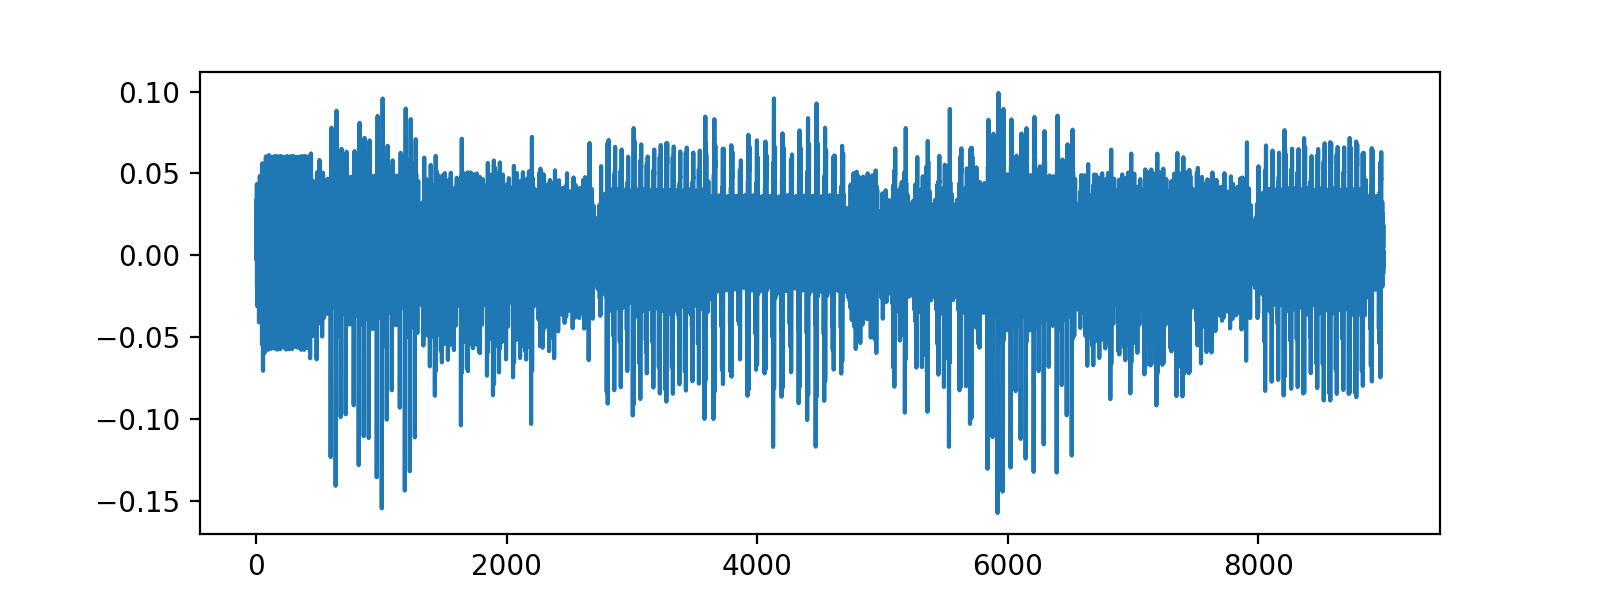

In [192]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (8,3)

plt.figure()
plt.plot(avg_trace)
#plt.plot(insert_0(1350, 2263, avg_trace_2), '-')
plt.show()

Round key (AK) : 500 - 1345
Sub bytes (SB) : 1350 - 2263

In [195]:
scope.adc.samples = 5800 - 5000 # MC_high_index = 5800
scope.adc.offset = 5000 # MC_low_index = 5000

key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)


plaintext = [0x01, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x03, 0x00] + [0x00, 0x00, 0x00, 0x04]
plaintext_p = plaintext.copy()
set_u = 0xFF

start = time.time_ns()
encrypt_p_power_repeat_n(plaintext, 100)
end = time.time_ns()

print(f"Time taken estimated for attack: {(end - start)*256/10**9/60} min")
print(f"Time taken to obtain one stable power trace is : {(end - start)/10**9} sec")


avg_trace = encrypt_p_power_repeat_n(plaintext, 100)
avg_trace_p = encrypt_p_power_repeat_n(plaintext_p, 100)

for k in range(4):
    res= find_u_activating_jth_column(avg_trace, plaintext.copy(), k)
    print(f"u_i activating {k}th column are : {res}")

Time taken estimated for attack: 7.895041480533333 min
Time taken to obtain one stable power trace is : 1.850400347 sec
u_i activating 0th column are : [0, 5, 10, 15]
u_i activating 1th column are : [3, 4, 9, 14]
u_i activating 2th column are : [2, 7, 8, 13]
u_i activating 3th column are : [1, 6, 11, 12]


In [196]:
# 1
# Find {u0, u1, u2, u3} (ones that activate 0th column)  with plaintext
set_u_act_0_col_pt = find_u_activating_jth_column(avg_trace, plaintext.copy(), 0)
# Find {u0, u1, u2, u3} (ones that activate 0th column)  with plaintext'
set_u_act_0_col_pt_p = find_u_activating_jth_column(avg_trace_p, plaintext_p.copy(), 0)

In [197]:
print(set_u_act_0_col_pt)
print(set_u_act_0_col_pt_p)

[0, 5, 10, 15]
[0, 5, 10, 15]


In [198]:
# 1. p_u2 = p_u2', p_u3 = p_u3'
assert plaintext[set_u_act_0_col_pt[2]] == plaintext_p[set_u_act_0_col_pt_p[2]]
assert plaintext[set_u_act_0_col_pt[3]] == plaintext_p[set_u_act_0_col_pt_p[3]]

In [208]:
def algo2_modified(p, i, h = 0):
    assert h == 0 or h == 255
    old_offset = scope.adc.offset
    old_samples = scope.adc.samples
    print(old_offset)
    print(old_samples)
    
    # SB(1) : 1390 - 2200
    scope.adc.offset = 1350
    scope.adc.samples = 2263
    print(scope.adc.offset)
    print(scope.adc.samples)
    
    res = 0x00
    p[i] = 0x00
    e = encrypt_p_power_repeat_n(p, 100)
    e_count = np.mean(np.abs(e))
    for t in range(1, 256):
        print(hex(t) + " " + hex(res) + " " +str(e_count)[:8],end = '\r')
        p[i] = t
        e_p = encrypt_p_power_repeat_n(p, 100)
        #e_p_count = np.count_nonzero(np.array(e_p) - np.array(e) > 0)
        #e_count = np.count_nonzero(np.array(e_p) - np.array(e) < 0)
        #e_count = len(e) - e_p_count
        #e_count = np.sum(np.abs(np.array(e)))
        #e_p_count = np.sum(np.abs(np.array(e_p)))
        
        e_p_count = np.mean(np.abs(e_p))
        e_count = np.mean(np.abs(e))
        
        
        if e_p_count < e_count:
            if h == 0:
                res = t
                e = e_p
        elif e_p_count > e_count:
            if h == 255:
                res = t
                e = e_p 
                
    scope.adc.offset = old_offset
    scope.adc.samples = old_samples
    return res

In [200]:
# 2.
def set_to_HW_0_in_pt(plaintext, byte_index_0, byte_index_1, step):
    tmp = plaintext.copy()
    res1 = algo2_modified(tmp, byte_index_0, 0)
    print(f"Step {step}: p_u_{byte_index_0}: {hex(res1)}")
            
    tmp = plaintext.copy()
    res2 = algo2_modified(tmp, byte_index_1, 0)
    print(f"Step {step}: p_u_{byte_index_1}: {hex(res2)}")
        
    return res1, res2

In [201]:
# 3.
def set_to_HW_8_in_pt_p(plaintext_p, byte_index, step):
    tmp = plaintext_p.copy()
    res = algo2_modified(tmp, byte_index, 255)
    print(f"Step {step}: p_u_{byte_index}_p: {hex(res)}")
  
    return res

In [202]:
# 4
def set_to_delta_MC_0_in_pt_p(plaintext, plaintext_p, byte_index, delta_1_col_index, step):
    tmp = plaintext.copy()
    tmp2 = plaintext_p.copy()

    scope.adc.offset = 5800 # AK_low_index = 5800
    scope.adc.samples = 6550 - 5800 # AK_high_index = 6550
    power_trace_AK_1 = np.array(encrypt_p_power_repeat_n(plaintext, 50))[:]
    
    print(f"Byte index is {byte_index}")
    print(f"Col index is {delta_1_col_index}")
    for i in range(256):
        tmp2[byte_index] = i

        var_bar = tmp[byte_index]

        power_trace_AK_1_p = np.array(encrypt_p_power_repeat_n(tmp, 50))[:]

        if np.max(np.abs(power_trace_AK_1_p - power_trace_AK_1)) < 0.01:
            print("Sol found")
            if var_bar != i:
                print(f"Step {step}: p_u_{byte_index}_p: {hex(i)}")
                res = i
                return res
    raise Exception("Solution not found")

In [203]:
#5
def compute_H(plaintext_p, byte_index, step):
    tmp = plaintext_p.copy()

    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    
    w1 = algo2(tmp, set_u_act_0_col_pt_p[1]) 
    
    print(f"  Step {step}: H(b_u({byte_index})_p = {w1}")
    print(f"= Step {step}: H(b_u({byte_index})_p = {HW[plaintext_state[byte_index//4][byte_index%4]]}")
    print(f"Step {step}: x_({step})_p = {hex(plaintext_state[byte_index//4][byte_index%4])}")
    return HW[plaintext_state[byte_index//4][byte_index%4]], hex(plaintext_state[byte_index//4][byte_index%4])


In [209]:
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
set_up(key)
plaintext = [0x01, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x03, 0x00] + [0x00, 0x00, 0x00, 0x04]
plaintext_p = plaintext.copy()

scope.adc.samples = 9000
scope.adc.offset = 0

u_0 = 0
u_1 = 5
u_2 = 10
index_255 = [u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_2]
index_x   = [u_1, u_0, u_1, u_0, u_1, u_0, u_1, u_0, u_2, u_0]
delta_i   = [0, 0, 1, 1, 2, 2, 3, 3, 0, 0]
w_i = []
x_i = []

save_u0_u1 = False
save_u1_u0 = False


    
for d_0_index, d_1_index, i_index, step in zip(index_255, index_x, delta_i, list(range(len(index_x)))):
    print(f"Filter equ nbr : {step}")
    plaintext = [0x01, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x03, 0x00] + [0x00, 0x00, 0x00, 0x04]
    plaintext_p = plaintext.copy()
    
    if step%2 == 0 and step < 8: 
        if save_u0_u1 == False:
            plaintext[d_0_index], plaintext[d_1_index] = set_to_HW_0_in_pt(plaintext, d_0_index, d_1_index, step)
            plaintext_p[d_0_index] = set_to_HW_8_in_pt_p(plaintext_p, d_0_index, step)
            tmp_HW_0_d0_u0_u1 = plaintext[d_0_index]
            tmp_HW_0_d1_u0_u1 = plaintext[d_1_index]
            tmp_HW_8_d0_u0_u1 = plaintext_p[d_0_index]
            save_u0_u1 = True
        else:
            plaintext[d_0_index], plaintext[d_1_index], plaintext_p[d_0_index] = tmp_HW_0_d0_u0_u1, tmp_HW_0_d1_u0_u1, tmp_HW_8_d0_u0_u1 
        
    elif step%2 == 1 and step < 8:
        if save_u1_u0 == False:
            plaintext[d_0_index], plaintext[d_1_index] = set_to_HW_0_in_pt(plaintext, d_0_index, d_1_index, step)
            plaintext_p[d_0_index] = set_to_HW_8_in_pt_p(plaintext_p, d_0_index, step)
            tmp_HW_0_d0_u1_u0 = plaintext[d_0_index]
            tmp_HW_0_d1_u1_u0 = plaintext[d_1_index]
            tmp_HW_8_d0_u1_u0 = plaintext_p[d_0_index]
            save_u1_u0 = True
        else:
            plaintext[d_0_index], plaintext[d_1_index], plaintext_p[d_0_index] = tmp_HW_0_d0_u1_u0, tmp_HW_0_d1_u1_u0, tmp_HW_8_d0_u1_u0
        
    else:
        plaintext[d_0_index], plaintext[d_1_index] = set_to_HW_0_in_pt(plaintext, d_0_index, d_1_index, step)
        plaintext_p[d_0_index] = set_to_HW_8_in_pt_p(plaintext_p, d_0_index, step)
        
    plaintext_p[d_1_index] = set_to_delta_MC_0_in_pt_p(plaintext, plaintext_p, d_1_index, i_index, step)
    print(plaintext)
    print(plaintext_p)
    compute_d_i(plaintext, plaintext_p, step)
    tmp1, tmp2 = compute_H(plaintext_p, d_1_index, step)
    w_i += [tmp1]
    x_i += [int(tmp2[2:],16)]

print(f"w_i = {w_i}")
print(f"x_i = {x_i}")

Filter equ nbr : 0
0
9000
1350
2263
Step 0: p_u_0: 0x79
0
9000
1350
2263
Step 0: p_u_5: 0x9e
0
9000
1350
2263
Step 0: p_u_0_p: 0x56
Byte index is 5
Col index is 0


Exception: Solution not found

In [207]:
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
plaintext = [0x01, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x03, 0x00] + [0x00, 0x00, 0x00, 0x04]

response = AES_128_enc(plaintext,  expand_key(key))
# print_byte_array_in_hex(response)

set_up(key)
encrypt_p_power(plaintext)
# response = target.simpleserial_read('r', 16)
# print_byte_array_in_hex(bytes(response))


#scope.adc.offset = 1390 # SB1_low_index = 1390
#scope.adc.samples = 2200 - 1390 # SB1_high_index = 2200
#scope.adc.offset = 610 # AK0_low_index = 1390
#scope.adc.samples = 1265 # AK0_high_index = 2200
scope.adc.offset = 1350
scope.adc.samples = 2263
            
key = expand_key(key)

tmp = plaintext.copy()
for i in range(256):
    tmp[0] = i
    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    if plaintext_state[0][0] == 0x00:
        print(f"Res: p_u_0: {hex(i)}")

start = time.time_ns()
res = algo2_modified(plaintext, 0, h = 0)
end = time.time_ns()
print(f"Time taken: {(end - start)/10**9/60} min")

print(f"res = {hex(res)}" + " " * 20)

"""
plaintext[0] = 0x01
plaintext_state = bytes2matrix(plaintext)
add_round_key(plaintext_state, key[0])  
sub_bytes(plaintext_state)
objective = HW[plaintext_state[0][0]]
print(f"HW : {objective}")

e = encrypt_p_power_repeat_n(plaintext, 100)

print(f"mean : {np.mean(np.abs(e))}")

for i in range(120, 256):
    plaintext[0] = i
    plaintext_state = bytes2matrix(plaintext)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)

    e_p = encrypt_p_power_repeat_n(plaintext, 100)
        
    res = np.mean(np.abs(e_p))
    res2 = np.mean(np.abs(e))
    
    print(f"SB1_0,0 i={hex(i)}: {HW[plaintext_state[0][0]]}, {res}")
    
   
    if objective >= HW[plaintext_state[0][0]] and res2 >= res:
        pass
        #print(f"Correct i = {i}")
        #print(tmp1)
        #print(f"SB1_0,0 i={i}: {HW[plaintext_state[0][0]]}")
    elif objective <= HW[plaintext_state[0][0]] and res2 <= res:
        pass
        #print(f"Correct i = {i}")
        #print(tmp1)
        #print(f"SB1_0,0 i={i}: {HW[plaintext_state[0][0]]}")
    else: 
        print(f"Wrong i = {i}")
        print(objective)
        print(f"SB1_0,0 i={i}: {HW[plaintext_state[0][0]]}")
        
        print(res)
        print(res2)
        
        print(np.mean(np.array(e_p)))
        print(np.mean(np.array(e)))
        
        %matplotlib notebook
        import matplotlib.pylab as plt

        plt.rcParams["figure.figsize"] = (8,3)

        plt.figure()
        plt.plot(np.array(e) - np.array(e_p), label = "e - e_p")
        plt.legend(loc="upper left")
        plt.show()
        
        break
"""
None

Res: p_u_0: 0x79
Time taken: 9.293117857766667 min
res = 0x79   


'\nplaintext[0] = 0x01\nplaintext_state = bytes2matrix(plaintext)\nadd_round_key(plaintext_state, key[0])  \nsub_bytes(plaintext_state)\nobjective = HW[plaintext_state[0][0]]\nprint(f"HW : {objective}")\n\ne = encrypt_p_power_repeat_n(plaintext, 100)\n\nprint(f"mean : {np.mean(np.abs(e))}")\n\nfor i in range(120, 256):\n    plaintext[0] = i\n    plaintext_state = bytes2matrix(plaintext)\n    add_round_key(plaintext_state, key[0])  \n    sub_bytes(plaintext_state)\n\n    e_p = encrypt_p_power_repeat_n(plaintext, 100)\n        \n    res = np.mean(np.abs(e_p))\n    res2 = np.mean(np.abs(e))\n    \n    print(f"SB1_0,0 i={hex(i)}: {HW[plaintext_state[0][0]]}, {res}")\n    \n   \n    if objective >= HW[plaintext_state[0][0]] and res2 >= res:\n        pass\n        #print(f"Correct i = {i}")\n        #print(tmp1)\n        #print(f"SB1_0,0 i={i}: {HW[plaintext_state[0][0]]}")\n    elif objective <= HW[plaintext_state[0][0]] and res2 <= res:\n        pass\n        #print(f"Correct i = {i}")\n  

### Attack on S Box

In [ ]:
plaintext = [0x01, 0x00, 0x00, 0x00] + [0x00, 0x02, 0x00, 0x00] + [0x00, 0x00, 0x03, 0x00] + [0x00, 0x00, 0x00, 0x04]
plaintext_p = plaintext.copy()
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
key = expand_key(key)

import galois
GF = galois.GF(2**8, irreducible_poly="x^8 + x^4 + x^3 + x + 1")
MC_a, MC_b, MC_c, MC_d = GF([2, 3, 1, 1])

M = GF([[MC_a, MC_b, MC_c, MC_d],
        [MC_d, MC_a, MC_b, MC_c],
        [MC_c, MC_d, MC_a, MC_b],
        [MC_b, MC_c, MC_d, MC_a]])

M_inv = np.linalg.inv(M)
MC_e, MC_f, MC_g, MC_h = M_inv[0, 0], M_inv[0, 1], M_inv[0, 2], M_inv[0, 3]

coef_M_inv = ["e", "f", "g", "h"]

u_index = [0, 5, 10, 15]
 
def find_p_0123_Sboox_0(key):
    res = [None, None, None, None]
    for i in range(256):
        for j in range(4):
            if HW[sbox[(i ^ key[0][u_index[j]//4][u_index[j]%4]) % 256]] == 0:
                print(f"p_{u_index[j]} = {hex(i)}")
                res[j] = i
    return res
    
plaintext[u_index[0]], plaintext[u_index[1]], plaintext[u_index[2]], plaintext[u_index[3]] = find_p_0123_Sboox_0(key)

def find_d0123_convergence(plaintext, plantext_p):
    tmp = plaintext.copy()
    tmp2 = plantext_p.copy()
    
    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    shift_rows(plaintext_state)
    mix_columns(plaintext_state)
    
    for d_0 in range(1, 256):
        tmp2[u_index[0]] = tmp[u_index[0]] ^ d_0 
        for d_1 in range(1, 256):
            tmp2[u_index[1]] = tmp[u_index[1]] ^ d_1
            for d_2 in range(1, 256):
                tmp2[u_index[2]] = tmp[u_index[2]] ^ d_2 
                for d_3 in range(1, 256):
                    tmp2[u_index[3]] = tmp[u_index[3]] ^ d_3 

                    plaintext_state_p = bytes2matrix(tmp2)
                    add_round_key(plaintext_state_p, key[0])
                    sub_bytes(plaintext_state_p)
                    shift_rows(plaintext_state_p)
                    mix_columns(plaintext_state_p)
                        
                    nbr_same = 0
                    for j in range(4):
                        if plaintext_state[0][j] == plaintext_state_p[0][j]:
                            nbr_same += 1
                    if nbr_same == 3:
                        return d_0, d_1, d_2, d_3, j, tmp2


d_0, d_1, d_2, d_3, conv_type, plaintext_p = find_d0123_convergence(plaintext, plaintext_p)

d_list = [d_0, d_1, d_2, d_3]

plaintext_p[0] = plaintext[0] ^ d_0 
plaintext_p[1] = plaintext[1] ^ d_1
plaintext_p[2] = plaintext[2] ^ d_2 
plaintext_p[3] = plaintext[3] ^ d_3 

plaintext_state = bytes2matrix(plaintext)
add_round_key(plaintext_state, key[0])
sub_bytes(plaintext_state)
shift_rows(plaintext_state)
mix_columns(plaintext_state)
print_state_to_hex_str(plaintext_state)
print(plaintext_state)

plaintext_state = bytes2matrix(plaintext_p)
add_round_key(plaintext_state, key[0])
sub_bytes(plaintext_state)
shift_rows(plaintext_state)
mix_columns(plaintext_state)
print_state_to_hex_str(plaintext_state)
print(plaintext_state)

In [ ]:
def compute_H(plaintext, byte_index):
    tmp = plaintext.copy()

    plaintext_state = bytes2matrix(tmp)
    add_round_key(plaintext_state, key[0])  
    sub_bytes(plaintext_state)
    
    return HW[plaintext_state[byte_index//4][byte_index%4]]

w_list = []

for i in range(4):
    H = compute_H(plaintext_p, u_index[i])
    w_list += [H]
    print(f"H(p_u_{u_index[i]},SB_1) : {H}")

In [ ]:
# 0, 1, 2, 3
# e, f, g, h

# Column rhs eq. 12
# e, h, g ,f
# f, e, h, g
# g, f, e, h
# h, g, f, e

# Map : 
# 0 -> 0
# 1 -> 3
# 2 -> 2
# 3 -> 1

def map_M_coeff(x, conv_type):
    tmp = (x-conv_type)%4
    return tmp**((tmp+1)%2) * ((tmp+2)%4)**(tmp%2)  

In [ ]:
L = []

for lambda_ in range(1, 256):
    lambda_GF = GF(lambda_)
    L_elem = []
    for i in range(4):
        L_elem += [HW[M_inv[0, map_M_coeff(i, conv_type)]*lambda_GF]]
    L += [L_elem]

for i in range(len(L)):
    if L[i] == w_list:
        print(f"lambda = {i+1}")
        lambda_ = GF(i + 1)

In [ ]:
for i in range(4):
    tmp = u_index[i]
    print(f"b_{tmp},SB(1) + b'_{tmp},SB(1) = T(p_{tmp}={plaintext[tmp]} + k_{tmp}={key[0][tmp//4][tmp%4]}) + T(p_{tmp}={plaintext[tmp]} + k_{tmp}={key[0][tmp//4][tmp%4]} + d_{tmp} = {d_list[i]} ) = ({coef_M_inv[map_M_coeff(i, conv_type)]} = {M_inv[0, map_M_coeff(i, conv_type)]}) * (λ = {lambda_})") 
      
    assert sbox[GF(plaintext[tmp]) + GF(key[0][tmp//4][tmp%4]) + GF(d_list[i])] == GF(M_inv[0, map_M_coeff(i, conv_type)]) * lambda_
      

### Disconnect board

In [ ]:
scope.dis()
target.dis()